# Predicting Airbnb Price in European Cities 

---

**Group 15** <br>
Mathew <br>
Marcus <br>
Zahra <br>
Alizah <br>

---

# Introduction

Airbnb has revolutionized the short-term rental market, making tourism and travel more accessible and convenient. As a popular alternative to traditional hotels, hosts can monetize their properties by listing it on the platform, enabling guests to customize and enrich their travel experiences. In Europe, tourism plays a significant role in many cities’ economies, and understanding the factors that influence listing prices will help explain what truly adds value to a stay. 

#### Literature Review

Listing reputation was associated with a negative effect on price, as hosts with lower prices may attract more guests and reviews ([Toader, Victor, et al, 2021](https://doi.org/10.1080/1331677x.2021.1962380)). The same study also associated the number of bedrooms and guest capacity with the largest price changes. 

Listing prices have also been concluded to be spatially dependent, changing with distance from city centre, distance to the nearest metro station, and distances to major attractions ([Gyódi, Karol, and Łukasz Nawaro, 2021](https://doi.org/10.1016/j.tourman.2021.104319)). The authors determined that Airbnb prices decrease further from city centre and metro stations, but increase in the vicinity of popular tourist attractions and restaurants.

#### **Our Question:** Which factors are most useful for predicting the price of an Airbnb listing?

Confirming the importance of location and other factors, and being able to estimate listing prices with good accuracy, is helpful for both hosts and guests. Beyond tourism management, understanding Airbnb prices will also be informative for urban planning, expanding upon previous studies. 

## Data Description:
Our analysis will use the dataset [Airbnb Prices in European Cities](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data).

The data appears to be aggregated from Airbnb listings from several major European cities. The cities we will focus on are London, Rome, and Budapest, on weekends and weekdays, for a total of `23042` observations. 

There are 20 variables in the original dataset, but we drop `id`, `attr_index`, `attr_index_norm`, `rest_index`, and `rest_index_norm` as they aren’t explained in detail. This leaves us with 15 variables (table from Assignment 2):

| Column name   | Description   | Data Type     |
| ------------- | ------------- | ------------- |
| `realSum` | The total price of the Airbnb listing (Euros). | Numeric |
| `room_type` | The type of room being offered (e.g. private, shared, etc.). | Categorical |
| `room_shared` | Whether the room is shared or not. | Boolean |
| `room_private` | Whether the room is private or not. | Boolean |
| `person_capacity` | The maximum number of people that can stay in the room. | Numeric |
| `host_is_superhost` | Whether the host is a superhost or not. | Boolean |
| `multi` | Whether the listing is for multiple rooms or not. | Boolean |
| `biz` | Whether the listing is for business purposes or not. | Boolean |
| `cleanliness_rating` | The cleanliness rating of the listing. | Numeric |
| `guest_satisfaction_overall` | The overall guest satisfaction rating of the listing. | Numeric |
| `bedrooms` | The number of bedrooms in the listing. | Numeric |
| `dist` | The distance from the city centre. | Numeric |
| `metro_dist` | The distance from the nearest metro station. | Numeric |
| `lng` | The longitude of the listing. | Numeric |
| `lat` | The latitude of the listing. | Numeric |


The following two variables will be added to the data when imported: 

| Column name   | Description   | Data Type     |
| ------------- | ------------- | ------------- |
| `city` | The city location of the Airbnb listing. | Categorical |
| `isWeekend` | Whether the listing is for weekends or not. | Boolean |


# Methods and Results
## a) Exploratory Data Analysis
We start by reading our data and drop the columns we do not need (`id`, `attr_index`, `attr_index_norm`, `rest_index` and `rest_index_norm`). We will also drop `lng` and `lat`, because they must be considered in a combined and discrete manner to be meaningful. We will also correct the following columns:

- `room_type` from \<chr\> to factor (\<fct\>) 
- `multi` & `biz` from \<dbl\> to logicals (\<lgl\>) 

In [1]:
# install.packages("mltools")
# install.packages("glmnet")
# install.packages("leaps")
# You may need to run these functions if certain packages are not already installed.

In [2]:
# Libraries & Packages
library(tidyverse)
library(dplyr)
library(mltools)    # rbind() and rmse()
library(rsample)    # data splitting
library(MASS)       # stepAIC()
library(car)        # vif()
library(tidymodels) # recipes (for standardizing)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──



In [3]:
# Main developer: Alizah (Referenced from Assignment 2 Project Planning)
# Contributor: Marcus (modified read function)

# Function to format & read data: 
# select vars from dataset and add city name + if it's weekend data
tidy_data <- function(path, cityName, isWeekend) {
    data <- read_csv(path, show_col_types = FALSE) %>%
            dplyr::select(-...1, -attr_index, -attr_index_norm, -rest_index, 
                          -rest_index_norm, -lng, -lat) # Drop columns
    data$city <- as.factor(cityName)        # The city location of the Airbnb listing (Categorical)
    data$isWeekend <- as.logical(isWeekend) # Whether the listing is for weekends or not. (Boolean)
    return(data)
}

# Import and format data with tidy_data()
london_weekdays <- tidy_data("data/london_weekdays.csv", "London", 0)
london_weekends <- tidy_data("data/london_weekends.csv", "London", 1)
rome_weekdays <- tidy_data("data/rome_weekdays.csv", "Rome", 0)
rome_weekends <- tidy_data("data/rome_weekends.csv", "Rome", 1)
budapest_weekdays <- tidy_data("data/budapest_weekdays.csv", "Budapest", 0)
budapest_weekends <- tidy_data("data/budapest_weekends.csv", "Budapest", 1)

# Merge all the data together
data <- rbind(london_weekdays, london_weekends, rome_weekdays, rome_weekends, budapest_weekdays, budapest_weekends)

# View the head and tail of the data
head(data, 3)
tail(data, 3)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,city,isWeekend
<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
570.0981,Entire home/apt,FALSE,FALSE,2,FALSE,0,0,10,98,1,5.301018,1.5889904,London,FALSE
297.9844,Private room,FALSE,TRUE,2,TRUE,1,0,10,99,1,2.198946,0.3792620,London,FALSE
336.7906,Private room,FALSE,TRUE,2,FALSE,1,0,10,96,1,2.322958,0.4531776,London,FALSE


realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,city,isWeekend
<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
162.8519,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,93,1,11.855169,7.9301629,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,90,1,1.669951,0.2725486,Budapest,TRUE
129.2475,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,93,1,1.669965,0.2725244,Budapest,TRUE


In [4]:
# Main developer: Matthew (Referenced from Assignment 2 Project Planning)
# Contributor: Zahra (Style Guide)

# Correct the columns with wrong type
data <- data %>%
    mutate(
        #Convert to factor
        across(c(room_type), as.factor),
        
        #Convert to logical
        across(c(multi, biz), as.logical)
    )

# View the corrected head of the data
head(data, 3)

realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,city,isWeekend
<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
570.0981,Entire home/apt,FALSE,FALSE,2,FALSE,FALSE,FALSE,10,98,1,5.301018,1.5889904,London,FALSE
297.9844,Private room,FALSE,TRUE,2,TRUE,TRUE,FALSE,10,99,1,2.198946,0.3792620,London,FALSE
336.7906,Private room,FALSE,TRUE,2,FALSE,TRUE,FALSE,10,96,1,2.322958,0.4531776,London,FALSE


In [5]:
# Main developer: Marcus (Referenced from Assignment 2 Project Planning)
# Contributor: Alizah (organized output)

# Inspect data structure
str(data)
cat("\n")

# Check for missing/NA values
cat("NA values present?: ", anyNA(data))
cat("\n")

# Compute summary statistics & check numbers
cat("Data dimensions: ", dim(data))
cat("\n\n")
cat("Summary of realSum")
summary(data$realSum)

tibble [23,042 × 15] (S3: tbl_df/tbl/data.frame)
 $ realSum                   : num [1:23042] 570 298 337 227 256 ...
 $ room_type                 : Factor w/ 3 levels "Entire home/apt",..: 1 2 2 2 2 2 2 2 2 1 ...
 $ room_shared               : logi [1:23042] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ room_private              : logi [1:23042] FALSE TRUE TRUE TRUE TRUE TRUE ...
 $ person_capacity           : num [1:23042] 2 2 2 2 3 2 2 2 4 3 ...
 $ host_is_superhost         : logi [1:23042] FALSE TRUE FALSE TRUE FALSE FALSE ...
 $ multi                     : logi [1:23042] FALSE TRUE TRUE TRUE FALSE FALSE ...
 $ biz                       : logi [1:23042] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ cleanliness_rating        : num [1:23042] 10 10 10 10 9 10 10 10 9 8 ...
 $ guest_satisfaction_overall: num [1:23042] 98 99 96 99 98 100 100 95 93 74 ...
 $ bedrooms                  : num [1:23042] 1 1 1 1 1 1 1 1 1 0 ...
 $ dist                      : num [1:23042] 5.3 2.2 2.32 5.71 3.26 ...

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   34.78   144.05   195.92   268.47   296.57 15499.89 

Above, we see `realSum` with a maximum value of `15499.89`, minimum of `34.78`, and a mean of `268.47`. This suggests the presence of outliers. 

Before we go further, we call `initial_split` (from `rsample`) to randomly split our dataset, stratified by `realSum` with 80/20 training-test split. Our question involves both inference and prediction, and splitting the data prevents us from making over-optimistic conclusions on our model, prevents post-inference problems and helps us get a less biased understanding of our model's scalability and performance. 

Let’s visualize the distribution of `realSum` with a histogram to further examine outliers.

In [6]:
# Main developer: Alizah

set.seed(1515)

# Split data between Training and Testing data, not standardized
data_split <- initial_split(data, prop = 0.8, strata = realSum)
training_data <- training(data_split)
testing_data <- testing(data_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


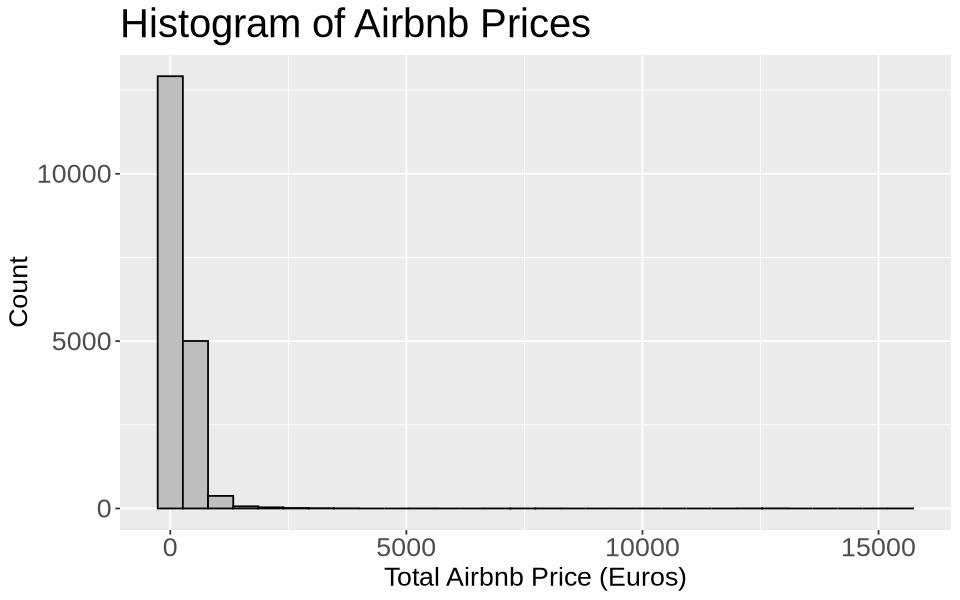

In [7]:
# Main developer: Marcus (Referenced from Assignment 2 Project Planning)
# Contributor: Zahra (Style Guide)

# Adjust size of plots
options(repr.plot.width = 8, repr.plot.height = 5)

# Plot a histogram of our response variable realSum
realSum_hist <- training_data %>%
    ggplot(aes(x = realSum)) +
    geom_histogram(fill = "gray", color = "black") +
    labs(
        title = "Histogram of Airbnb Prices", 
        x = "Total Airbnb Price (Euros)", 
        y = "Count"
    ) +
    theme(
        axis.text = element_text(size = 16), 
        axis.title = element_text(size = 16),
        title = element_text(size = 20)
    )

realSum_hist

Above, we see high outliers in `realSum`. Let’s filter them by removing the 95th percentile, grouped by cities, and plot again.

In [8]:
# Main developer: Matthew (Referenced from Assignment 2 Project Planning)
# Contributor: Zahra (Style Guide)

# Filtering Outliers from each city by removing listings above the 95th percentile
training_data_filt <- training_data %>% 
    group_by(city) %>%
    filter(realSum <= quantile(realSum, 0.95, na.rm = TRUE)) %>%
    ungroup()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


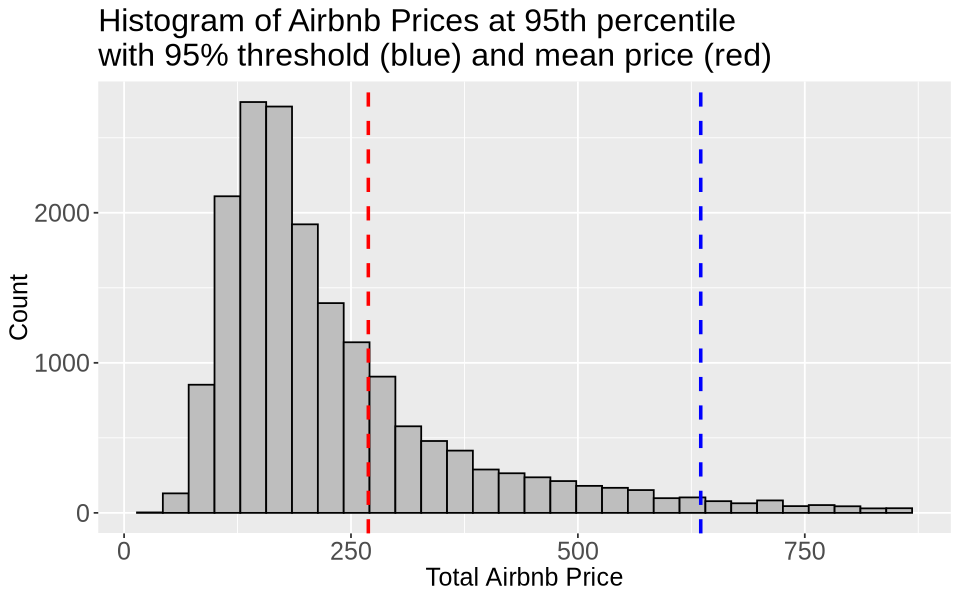

In [9]:
# Main developer: Marcus (Referenced from Assignment 2 Project Planning)
# Contributor: Zahra (Style Guide and Aesthetics)

# Plot filtered histogram with Mean and 95th Percentile lines
realSum_hist_filt <- training_data_filt %>%
    ggplot(aes(x = realSum)) +
    geom_histogram(fill = "gray", color = "black") +
    geom_vline(xintercept = mean(training_data$realSum), color = "red", 
               linetype = "dashed", size = 1) +
    geom_vline(xintercept = quantile(training_data$realSum, 0.95), color = "blue", 
               linetype = "dashed", size = 1) +
    # scale_x_continuous(breaks = seq(0, 1000, 100)) +
    ggtitle("Histogram of Airbnb Prices at 95th percentile\nwith 95% threshold (blue) and mean price (red)") +
    labs(x = "Total Airbnb Price", y = "Count") +
    theme(
        axis.text = element_text(size = 15), 
        axis.title = element_text(size = 15),
        title = element_text(size = 16)
    )
    
realSum_hist_filt

Our filtered data appears right-skewed. 95% of Airbnb price listings fall below about `900` grouped by city, but fall below about `640` for the entire dataset, so we need to explore `city`. There’s also low outliers under `100`, so we’ll drop them by filtering listings below the 5th percentile.

In [10]:
# Main developer: Matthew (Referenced from Assignment 2 Project Planning)

# Filter again to exclude lower 5%
training_data_filt <- training_data_filt %>%
    group_by(city) %>%
    filter(realSum >= quantile(realSum, 0.05, na.rm = TRUE)) %>%
    ungroup()

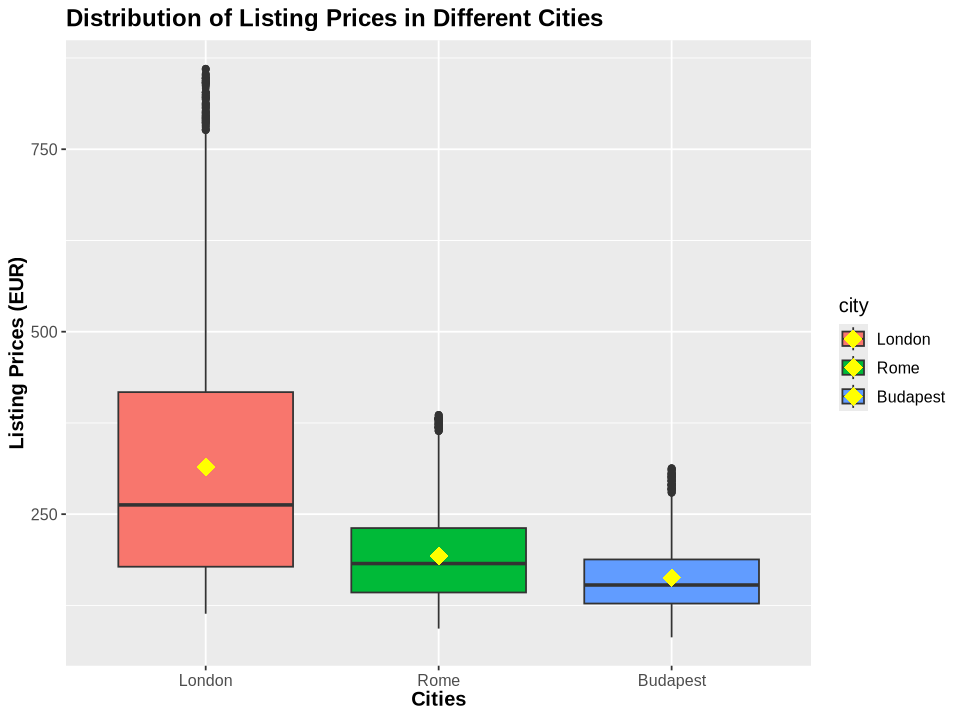

In [11]:
# Main developer: Matthew (Referenced from Assignment 2 Project Planning)
# Contributor: Zahra (Style Guide)

#Set plot size
options(repr.plot.height = 6, repr.plot.width = 8)

# Creating a Boxplot to examine distribution of listing prices by city
city_listing_plot <-
    training_data_filt %>%
    ggplot(aes(x = city, y = realSum, fill = city)) +
    geom_boxplot()+
    stat_summary(
        aes(x = city, y = realSum),
        fun = mean, 
        geom = "point", 
        colour = "yellow", 
        shape = 18, 
        size = 5
    ) +
    ggtitle("Distribution of Listing Prices in Different Cities") +
    xlab("Cities") +
    ylab("Listing Prices (EUR)") +
    theme(
        text = element_text(size = 12),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
city_listing_plot

The box plot above shows the distribution of listing prices across London, Rome and Budapest. 

- Budapest (Blue) appears to have the smallest variability as well as the lowest median and mean.
- London (Red) has the largest variability and the highest median and mean.
- Rome (Green) has a variability, median and mean higher than Budapest but lower than London.
- Budapest and Rome share a relatively similar spread, median and mean of listing prices to one another. However, London's wider distribution and higher median and mean may affect the goodness of fit of the model.

Lastly, let's plot a correlation heatmap to explore correlations between variables in the training set.

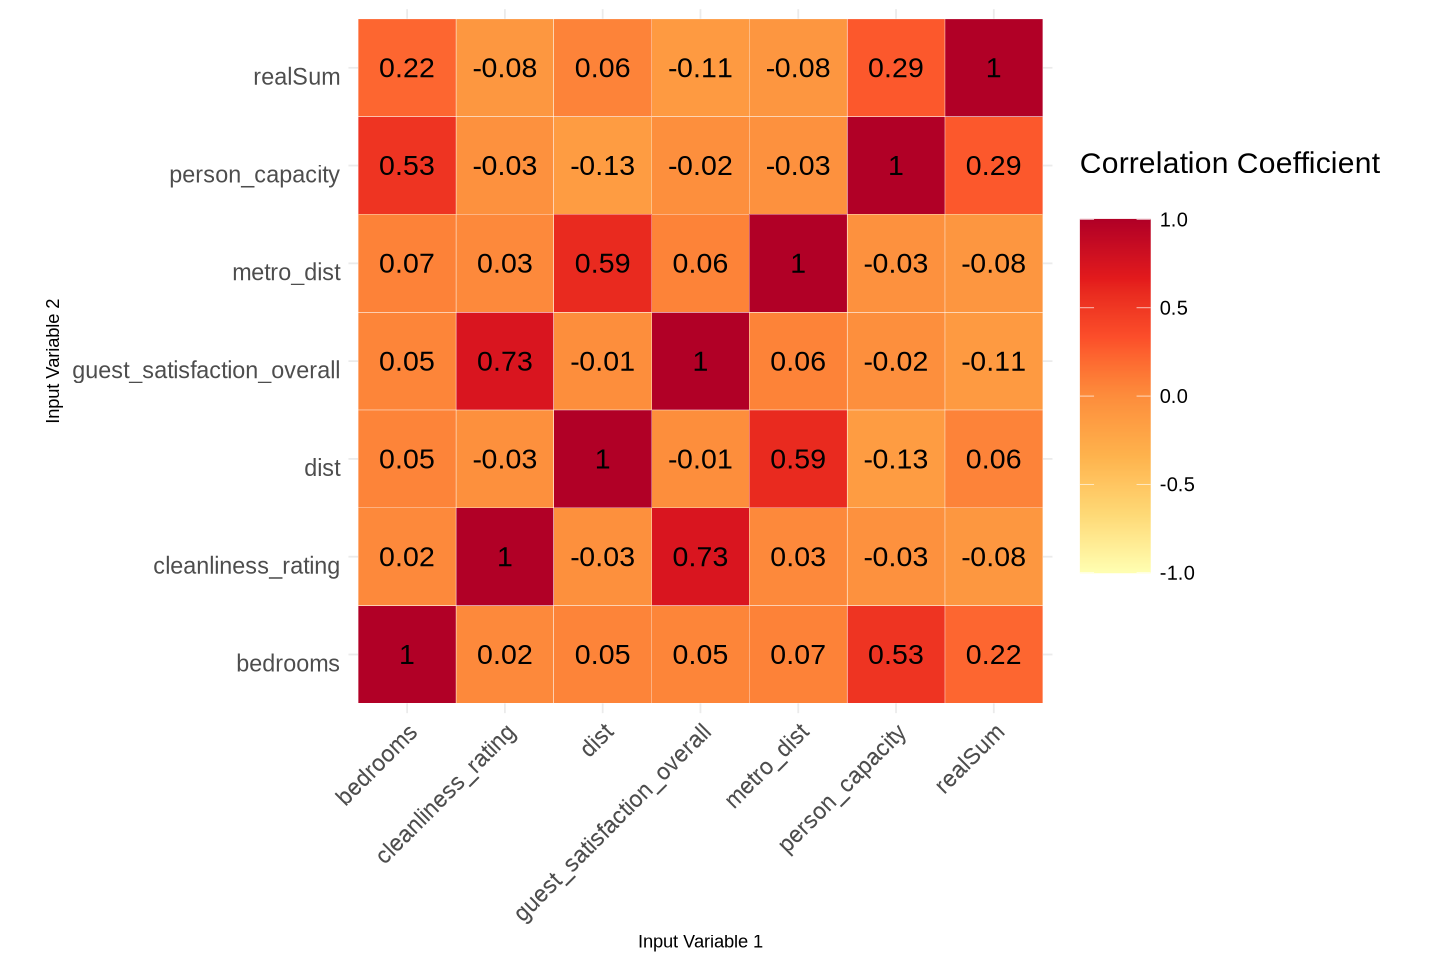

In [12]:
# Main Developer: Marcus (Referenced from STAT 301 Tutorial 3)

# Select only numeric, then get melted correlation matrix
training_corr_matrix <- 
    training_data_filt %>%
    dplyr::select(where(is.numeric)) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")


# Create a heatmap visualization
options(repr.plot.width = 12, repr.plot.height = 8) 

options(jupyter.plot_mimetypes = "image/png")

plot_corr_matrix <- training_corr_matrix %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
        palette =  "YlOrRd",
        direction = 1, 
        limits = c(-1.0, 1.0)
    ) +
    labs(x = "Input Variable 1", y = "Input Variable 2") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)

plot_corr_matrix

Above, there seem to be moderate (between `0.50` and `0.75`) correlations between:
- `person_capacity` and `bedrooms`
- `metro_dist` and `dist`
- `guest_satisfaction_overall` and `cleanliness_rating`

We will remove the variable less correlated with the response from each of these pairs (`bedrooms`, `metro_dist`, `guest_satisfaction_overall`).

In [13]:
training_data_filt <- dplyr::select(training_data_filt, -bedrooms, -metro_dist, -guest_satisfaction_overall)

## b) Analysis 

### Splitting & Initial Fit
We ensured the testing data did not leak into the model, using only the filtered training data to fit.

First, we fit a baseline (intercept-only) model as a point of comparison. Our main model used `stepAIC` to systematically select the most important factors for predicting our listing price. 

We chose `stepAIC` with forward selection, because `stepAIC` takes multicollinearity into account unlike LASSO regularization, which may randomly drop predictors with similar model contributions. It also considers categorical variables as a whole rather than by each dummy variable created, in contrast to `regsubsets`.

`stepAIC` with forward selection adds predictors one by one to the baseline model, choosing the predictor that yields the largest drop in AIC (a metric used to compare model fit). This process repeats until no further AIC improvement is possible, balancing overfitting and underfitting to find the least complex model with the best fit. 

### Checking Assumptions:
We assumed independence of observations. For additive models, we assumed no combined interactions (between predictors) that influence the response.

We check our model assumptions for linearity, normality, homoscedasticity and collinearity. Although we have enough observations (23042) to apply the CLT and assume normality, it is good to check.

Residuals vs. Fitted Plot (Figure 1):
- To check linearity, the plot should have the same number of points above/below the reference line at any value of fitted values. 
- To check homoscedasticity, the plot should not look like a “cone”.

Q-Q Plot (Figure 2): 
- To check normality, the plot should show points that align with the reference line.

To check for multicollinearity, we used `vif` to find highly collinear variables.

### Testing & Evaluation:
To validate assumptions, we log-transformed `realSum` and dropped collinear variables `room_shared` and `room_private`. We also standardized numerical predictors, using recipes from the `tidymodels` package and the training set.

Then, we used the transformed data with `stepAIC` and validated assumptions (Figure 3 & 4). We extracted selected predictors and fit them on an `lm` model.

We called `predict` with our finalized model and testing dataset and calculated the Root-Mean Squared Error using `rmse` (from `mltools`). RMSE is more sensitive to large errors because it squares them, helping us measure price prediction accuracy to a finer extent (every euro counts). Lower RMSE suggests better model accuracy. We also plotted our predicted and actual values as a visual aid of our model's performance (Figure 5). 

## c) Results

### Splitting & Initial Fit

In [14]:
# Main developer: Alizah

# Use the Intercept-Only Model as a Baseline for performance
baseline_model <- lm(realSum ~ 1, data = training_data_filt)

# Run forward selection starting from baseline model (full_model is the upper boundary)
full_model <- lm(realSum ~ ., data = training_data_filt)

step_model <- stepAIC(
    baseline_model, 
    scope = list(lower = baseline_model, upper = full_model),
    direction = "forward",
    trace = FALSE) # minimizes output

# THIS CELL MAY TAKE A WHILE TO RUN
# RESULTS SHOWN IN NEXT CELL

In [15]:
# Main developer: Alizah

# Viewing the selected predictors
init_formula = formula(step_model)
init_formula

realSum ~ city + room_type + dist + person_capacity + biz + cleanliness_rating + 
    multi + isWeekend + host_is_superhost

### Checking Assumptions

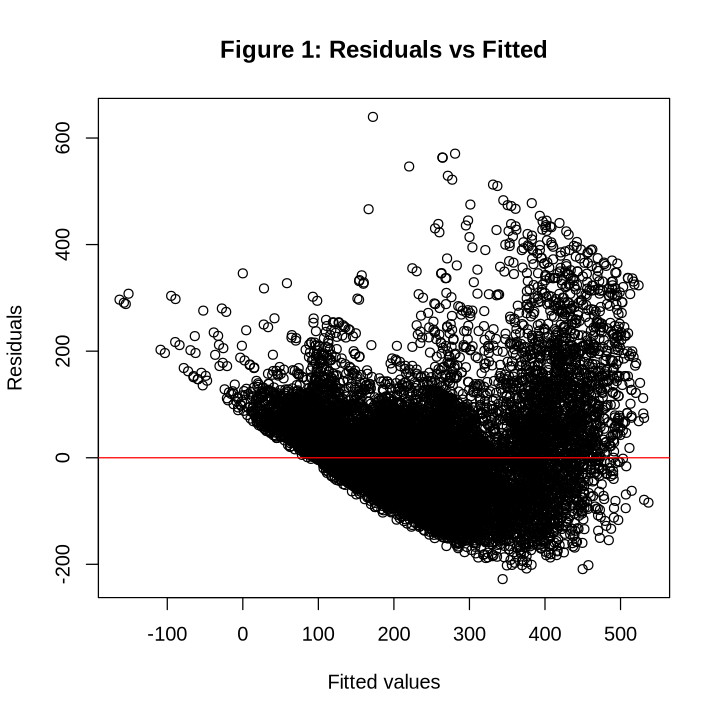

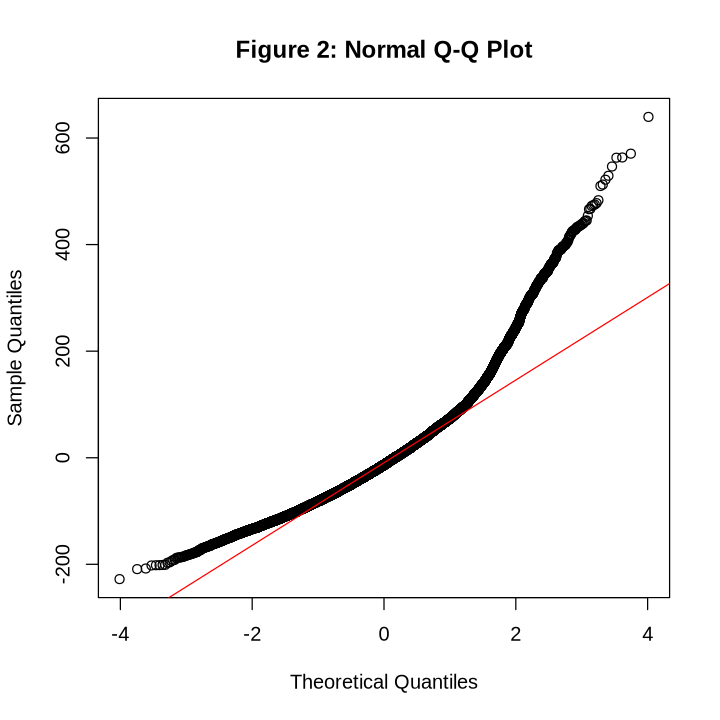

In [16]:
# Main developer: Alizah
# Collaborator: Zahra (Histogram of Residuals)
options(repr.plot.width = 6, repr.plot.height = 6) 

# Get Residuals
residuals <- resid(step_model)
fitted_vals <- fitted(step_model)

# 1. Residuals vs Fitted plot (for linearity & homoscedasticity)
plot(fitted_vals, residuals, xlab = "Fitted values", ylab = "Residuals")
abline(h = 0, col = "red")
title("Figure 1: Residuals vs Fitted")

# 2. QQ plot (for normality)
qqnorm(residuals, main = "Figure 2: Normal Q-Q Plot")
qqline(residuals, col = "red")

Examining the plots:

- **Figure 1: Residuals vs Fitted Plot:** The plot shows a different number of points above and below the reference line and has somewhat of a “cone” shape, suggesting a violation of the linearity and homoscedasticity assumptions. 

- **Figure 2: Q-Q Plot:** The points near the ends of the reference line deviate from the line significantly, suggesting a violation of normality.

Log-transforming the response `realSum` should validate these assumptions. Below, we check for multicollinearity.

In [17]:
# Main Developer: Alizah

# Find the aliases in the linear model 
# vif() will result in an error if there is perfect multicollinearity anywhere so we have to remove that first
alias_structure <- alias(lm(realSum ~ ., data = training_data_filt))
alias_vars <- rownames(alias_structure$Complete)
cat("Variables to Remove: ", alias_vars)

Variables to Remove:  room_sharedTRUE room_privateTRUE

We must remove 'room_shared' and 'room_private' in order to run `vif`, as they have perfect multicollinearity.

In [18]:
# Main Developer: Alizah

# Check GVIF with the remaining variables
data_noalias <- dplyr::select(training_data_filt, -room_shared, -room_private)
full_model_noalias <- lm(realSum ~ ., data = data_noalias)

cat("Table 1: vif output")
vif(full_model_noalias)

Table 1: vif output

,GVIF,Df,GVIF^(1/(2*Df))
room_type,1.559413,2,1.117481
person_capacity,1.419885,1,1.191589
host_is_superhost,1.139667,1,1.067552
multi,1.422863,1,1.192838
biz,1.492983,1,1.221877
cleanliness_rating,1.127441,1,1.061810
dist,1.493896,1,1.222250
city,1.690927,2,1.140332
isWeekend,1.003204,1,1.001601


The values under the last column are all $< \sqrt{5} \approx 2.24$, verifying minimal multicollinearity between the remaining predictors.

In [19]:
# Main developer: Marcus

# Standardizing both datasets
# Drop collinear variables
training_data_filt <- training_data_filt %>% dplyr::select(-room_shared, -room_private)
testing_data <- testing_data %>% dplyr::select(-room_shared, -room_private)

# Using tidymodels to create a transformation recipe using only the training data
# Standardize the data by log-transforming realSum and normalizing numerical variables
rec <- recipe(realSum ~ ., data = training_data_filt) %>%
  step_log(realSum) %>%
  step_normalize(all_numeric_predictors())

prep_rec <- prep(rec, training = training_data_filt)

# Apply recipe to training and testing set
training_data_std <- bake(prep_rec, new_data = training_data_filt)
testing_data_std  <- bake(prep_rec, new_data = testing_data)

# Check that transformations have been properly applied
head(training_data_std, 3)
head(testing_data_std, 3)

room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,dist,city,isWeekend,realSum
<fct>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<fct>,<lgl>,<dbl>
Private room,0.6844417,FALSE,TRUE,FALSE,-0.3787152,0.3065052,London,FALSE,4.862552
Private room,-0.8991835,FALSE,FALSE,FALSE,0.6419692,0.2219348,London,FALSE,4.959514
Private room,-0.8991835,FALSE,TRUE,FALSE,0.6419692,0.3998138,London,FALSE,4.939513


room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,dist,city,isWeekend,realSum
<fct>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<fct>,<lgl>,<dbl>
Private room,-0.8991835,FALSE,TRUE,FALSE,0.6419692,-0.58319155,London,FALSE,5.819461
Entire home/apt,-0.1073709,FALSE,FALSE,TRUE,-1.3993996,-0.01032346,London,FALSE,5.505363
Entire home/apt,0.6844417,FALSE,FALSE,TRUE,-0.3787152,0.28786093,London,FALSE,6.224927


### Testing & Evaluation:

In [20]:
# Main developer: Alizah

# Use the Intercept-Only Model, Standardized, as a Baseline for performance
baseline_model_std <- lm(realSum ~ 1, data = training_data_std)

# Calculate RMSE using baseline model on testing data
predictions <- predict(baseline_model_std, testing_data_std)

rmse_baseline <- mltools::rmse(testing_data_std$realSum, predictions)
cat("RMSE Baseline (Scaled): ", rmse_baseline)

actuals_original <- exp(testing_data_std$realSum)
predictions_original <- exp(predictions)
rmse_baseline_original <- mltools::rmse(actuals_original, predictions_original)
cat("\n")
cat("RMSE Baseline (Original, in Euros): ", rmse_baseline_original)

RMSE Baseline (Scaled):  0.5798149
RMSE Baseline (Original, in Euros):  312.472

In [21]:
# Main Developer: Alizah

# Run forward selection starting from baseline model (full_model is the upper boundary)
full_model_std <- lm(realSum ~ ., data = training_data_std)

step_model_std <- stepAIC(
    baseline_model_std, 
    scope = list(lower = baseline_model_std, upper = full_model_std),
    direction = "forward",
    trace = FALSE) # minimizes output

# THIS CELL MAY TAKE A WHILE TO RUN
# RESULTS SHOWN IN NEXT CELL

In [22]:
# Viewing the selected predictors
final_formula_std = formula(step_model_std)
final_formula_std

realSum ~ city + room_type + dist + person_capacity + cleanliness_rating + 
    biz + multi + isWeekend

In [23]:
# Main Developer: Alizah
# Contributor: Zahra(Style Guide)

# Create Final Prediction Model Using Selected Predictors
final_model = lm(final_formula_std, data = training_data_std)
summary(final_model) # Generate important summary statistics


Call:
lm(formula = final_formula_std, data = training_data_std)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98565 -0.21515 -0.02122  0.18781  1.59247 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)            5.908141   0.006436  917.925  < 2e-16 ***
cityRome              -0.647985   0.005908 -109.671  < 2e-16 ***
cityBudapest          -1.007832   0.008097 -124.468  < 2e-16 ***
room_typePrivate room -0.436156   0.005911  -73.781  < 2e-16 ***
room_typeShared room  -0.532473   0.044280  -12.025  < 2e-16 ***
dist                  -0.115165   0.002835  -40.621  < 2e-16 ***
person_capacity        0.107877   0.002764   39.026  < 2e-16 ***
cleanliness_rating     0.026518   0.002397   11.065  < 2e-16 ***
bizTRUE                0.067885   0.005896   11.514  < 2e-16 ***
multiTRUE              0.045232   0.005913    7.650 2.12e-14 ***
isWeekendTRUE          0.029966   0.004649    6.446 1.18e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘*

Above we see all model coefficients to be statistically significant. The estimates are in log units, and are multiplicative factors. We also note a good fit with an adjusted R-squared $\approx$ `0.61`. Interpretations are in discussion.

### Validating Assumptions

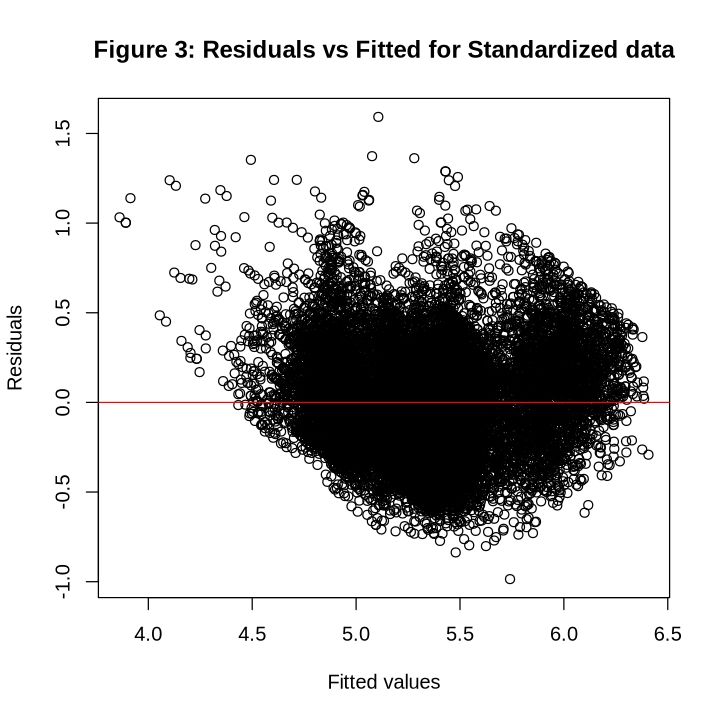

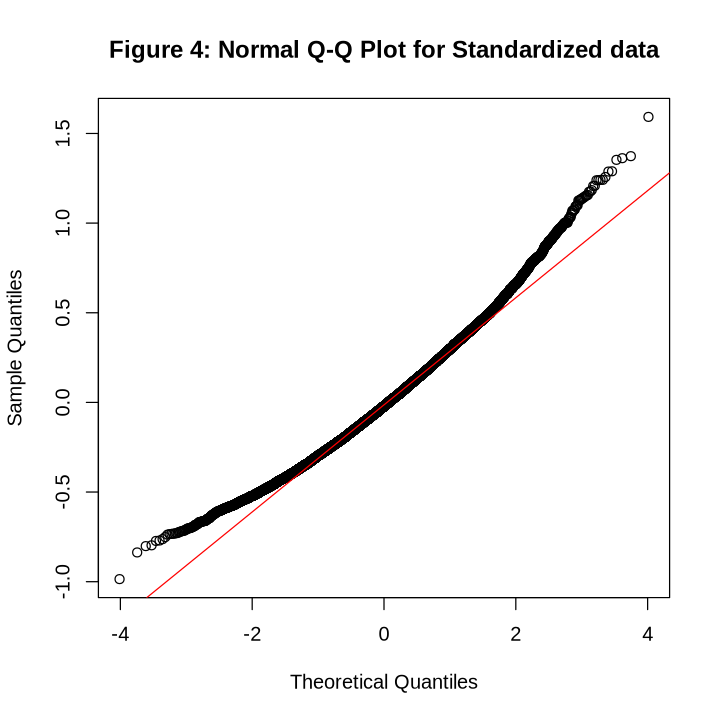

In [24]:
# Main developer: Alizah
# Collaborator: Zahra (Histogram of Residuals)

# Get Residuals
residuals <- resid(step_model_std)
fitted_vals <- fitted(step_model_std)

# 1. Residuals vs Fitted plot (for linearity & homoscedasticity)
plot(fitted_vals, residuals, xlab = "Fitted values", ylab = "Residuals")
abline(h = 0, col = "red")
title("Figure 3: Residuals vs Fitted for Standardized data")

# 2. QQ plot (for normality)
qqnorm(residuals, main = "Figure 4: Normal Q-Q Plot for Standardized data")
qqline(residuals, col = "red")

- **Figure 3: Residuals vs Fitted Plot, Standardized:** The points above and below the line appear equally distributed in an elliptical distribution, validating the assumption of linearity and homoscedasticity (constant variance). 
- **Figure 4: Q-Q Plot, Standardized:** The points fit better with the reference line, validating the assumption of normality. However, it remains slightly curved upwards at both ends.

Now, let’s evaluate the model.

In [25]:
# Main developer: Alizah
# Contributor: Zahra (Figure label)

# Predicting listing prices (realSum) with our model 
predictions <- predict(final_model, testing_data_std)
actuals <- testing_data_std$realSum

# Calculating RMSE
rmse_model <- mltools::rmse(testing_data_std$realSum, predictions)

actuals_original <- exp(actuals)
predictions_original <- exp(predictions)
rmse_model_original <- mltools::rmse(actuals_original, predictions_original)

# Compile metrics into a table
metrics <- data.frame(
    metric = c("Baseline RMSE", "Model RMSE"),
    log_value = c(rmse_baseline, rmse_model),
    value = c(rmse_baseline_original, rmse_model_original)
)

cat("Table 1: Result Metrics")
metrics

Table 1: Result Metrics

metric,log_value,value
<chr>,<dbl>,<dbl>
Baseline RMSE,0.5798149,312.4720
Model RMSE,0.3795960,272.8842


In table 1, we see that the stepAIC model has a better RMSE than our baseline model, which indicates that using our selected variables lead to a more accurate prediction of realSum values as compared to simply using the mean response value. 

As an added visual for our model performance, we plot model predictions against the observed values from our testing set.

Warning message:
“`geom_abline()`: Ignoring `mapping` because `slope` and/or `intercept` were
provided.”
`geom_smooth()` using formula = 'y ~ x'


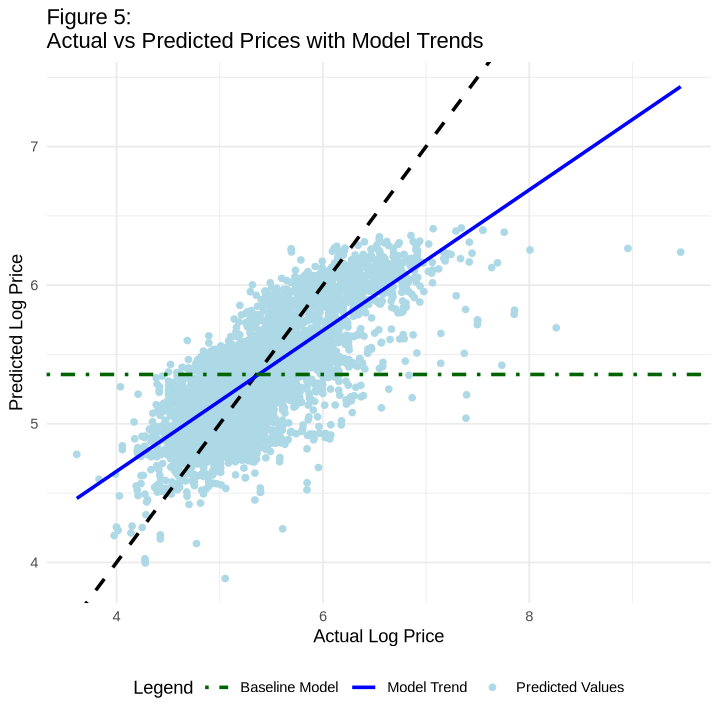

In [26]:
# Main Developer: Zahra 

# Plotting Model Predictions vs. Actuals
# Create plot data
plot_data <- data.frame(actuals = testing_data_std$realSum,
                        predictions = predict(final_model, testing_data_std))

# Extract the baseline model intercept
baseline_intercept <- coef(baseline_model_std)[1]

# Build plot
ggplot(plot_data, aes(x = actuals, y = predictions)) +
  geom_point(aes(color = "Predicted Values")) +
  
  # Ideal y = x line
  geom_abline(aes(color = "Ideal Fit"), slope = 1, intercept = 0, linetype = "dashed", linewidth = 1) +
  
  # Fitted trend line
  geom_smooth(aes(color = "Model Trend"), method = "lm", se = FALSE, linewidth = 1) +
  
  # Horizontal line for baseline model intercept
  geom_hline(aes(yintercept = baseline_intercept, color = "Baseline Model"),
             linetype = "dotdash", linewidth = 1) +
  
  # Manual color and legend mapping
  scale_color_manual(
    name = "Legend",
    values = c(
      "Predicted Values" = "lightblue",
      "Ideal Fit" = "red",
      "Model Trend" = "blue",
      "Baseline Model" = "darkgreen"
    )
  ) +
  
  labs(
    title = "Figure 5: \nActual vs Predicted Prices with Model Trends",
    x = "Actual Log Price",
    y = "Predicted Log Price"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")


Above (Figure 5), a model with perfect accuracy will have the line y=x (shown as the dashed diagonal line). We see that our model deviates from that line. For actual values lower than mean(realSum) (the intercept), our predictions appear to be overestimates. For actual values higher than mean(realSum), our predictions appear to be underestimates. 

# 3) Discussion

Through stepwise variable selection using `stepAIC`, we obtained the formula above. This formula contains 8 of the 15 analysis variables we started with.

We expected to find location, listing size, quality and host reputation to be important factors. From above, we confirm location, specifically distance to the city center (`dist`) and listings in Rome and Budapest (`city`), to be negatively associated with price. We also confirm listing size (`bedrooms`, `multi`) and quality (`cleanliness_rating`) to be positively associated with price. However, it appears that host reputation (`host_is_superhost`) was not selected as a strong predictor. Moreover, we note the following:

- Listings in Rome and Budapest are more negatively associated with price as compared to London. This matches our EDA.
- Private and Shared rooms are more negatively associated with price as compared to Entire home/apt. The magnitude of negative association is greater for Shared rooms as opposed to Private, which matches expectations.
- Listings for business-use are positively associated with price.
- Listings for weekends, as opposed to weekdays, do not have a significant association on price.

Our model had an RMSE $\approx$ `0.38` ($\approx$ 272 $\texteuro$), compared to the baseline with RMSE $\approx$ `0.58` ($\approx$ 312 $\texteuro$). 

## Improvements and Considerations

Below are some considerations for our analysis.

- Assumptions: If some assumptions are proven false, our results may be invalid or require further correction. 
- Overlooked Predictors & Relationships: There may be confounders, hidden interactions or other overlooked predictors excluded from the dataset or our model. For example, important variables could be the season, amenities, or neighbourhood crime rate. We also only briefly touched upon the moderately correlated numerical inputs.
- Part vs. Whole: Only looking at the data for specific cities (Rome, Budapest and London) could result in *Simpson’s paradox*, where the apparent associations for these three cities are not observed in other cities, or in Europe, or the world.

## Future Research

Future studies could examine the long-term trends in Airbnb price or consider more variables and interactions such as the season. However, it is important to note the risk of overfitting when including more predictors in a model. It may also be of interest to analyze Airbnb prices on a per-city basis, as well as the trends for different groupings of cities (ie. Capital cities), or the trends for other continents and countries. 

# 4) References

- Toader, Victor, et al. "Analysis of Price Determinants in the Case of Airbnb Listings." Economic Research-Ekonomska Istraživanja, vol. 35, no. 1, 2021, pp. 2493–2509. https://doi.org/10.1080/1331677x.2021.1962380.

- Gyódi, Karol, and Łukasz Nawaro. "Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach." Tourism Management, vol. 86, 2021, https://doi.org/10.1016/j.tourman.2021.104319.

- Gyódi, Karol, and Łukasz Nawaro. "Airbnb Prices in European Cities." Kaggle, 10 Mar. 2024, www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data.

